# Time-lagged setting: improving CVs
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/colab_setup/docs/notebooks/paper_experiments/paper_3_timelagged.ipynb)

## Setup

In [4]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    print('Colab environment found! Setting up the notebook dependencies')
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/colab_setup/colab_setup.sh', shell=True)
    subprocess.run('chmod +x ./colab_setup.sh && ./colab_setup.sh', shell=True)
    print('Done!')
    
# IMPORT PACKAGES
import torch
import lightning as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import subprocess

# IMPORT from MLCVS 
from mlcolvar.data import DictModule
from mlcolvar.core.transform import Normalization
from mlcolvar.core.transform.utils import Statistics
from mlcolvar.utils.fes import compute_fes
from mlcolvar.utils.io import create_dataset_from_files, load_dataframe
from mlcolvar.utils.plot import muller_brown_potential_three_states, plot_isolines_2D, plot_metrics, paletteFessa
from mlcolvar.utils.trainer import MetricsCallback


# IMPORT utils functions fo input generation
from utils.generate_input import gen_input_md,gen_input_md_potential,gen_plumed_tica

# Set seed for reproducibility
torch.manual_seed(42)

# ============================ SIMULATIONS VARIABLES ================================
run_calculations = False

if run_calculations:
    # plumed setup
    PLUMED_SOURCE = '/home/etrizio@iit.local/Bin/dev/plumed2-dev/sourceme.sh'
    PLUMED_EXE = f'source {PLUMED_SOURCE} && plumed'
    PLUMED_VES_MD = f"{PLUMED_EXE} ves_md_linearexpansion < input_md.dat"

    #test plumed
    subprocess.run(f"{PLUMED_EXE}", shell=True, executable='/bin/bash')

### System: modified Muller Brown potential

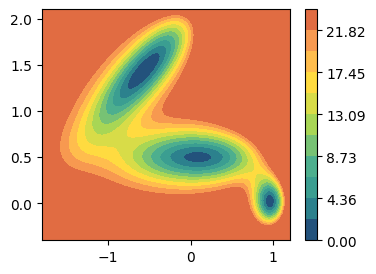

In [5]:
fig, ax = plt.subplots(figsize=(4,3))
plot_isolines_2D(muller_brown_potential_three_states, levels=np.linspace(0,24, 12), max_value=24, ax=ax)
MULLER_BROWN_FORMULA='0.15*(146.7-280*exp(-15*(x-1)^2+0*(x-1)*(y-0)-10*(y-0)^2)-170*exp(-1*(x-0.2)^2+0*(x-0)*(y-0.5)-10*(y-0.5)^2)-170*exp(-6.5*(x+0.5)^2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)^2)+15*exp(0.7*(x+1)^2+0.6*(x+1)*(y-1)+0.7*(y-1)^2))'

## Train DeepTICA CV

In [6]:
from mlcolvar.cvs import DeepTICA

RESULTS_FOLDER = 'results/timelagged'
# subprocess.run(f"rm -r {RESULTS_FOLDER}", shell=True)
# subprocess.run(f"mkdir {RESULTS_FOLDER}", shell=True)

### Load data

In [8]:
filenames = [ f'input_data/timelagged/opes-y/COLVAR' ]

# load file
df = load_dataframe(filenames,start=6000,stride=1)

# get descriptors
X = df.filter(regex='p.x|p.y').values
t = df['time'].values

# get logweights for time rescaling
beta = 1
bias = df['opes.bias'].values
bias -= np.max(bias)
logweights = beta*bias
df['logweights'] = logweights

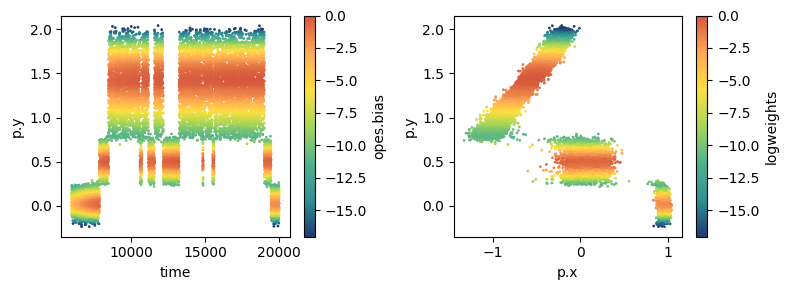

In [9]:
fig, axs = plt.subplots(1,2,figsize=(8,3))
df.plot.scatter('time','p.y',c='opes.bias',s=1, cmap='fessa', ax=axs[0])
df.plot.scatter('p.x','p.y',c='logweights',s=1,cmap='fessa', ax=axs[1])
plt.tight_layout()
plt.show()

### Create time-lagged dataset

In [10]:
from mlcolvar.utils.timelagged import create_timelagged_dataset
lag_time = 1

# build time-lagged dataset (composed by pairs of configs at time t, t+lag)
dataset = create_timelagged_dataset(X,t,lag_time=lag_time,logweights=logweights,progress_bar=True)

# create datamodule
datamodule = DictModule(dataset,lengths=[0.8,0.2],random_split=False,shuffle=False)

100%|██████████| 13997/13997 [00:01<00:00, 11530.86it/s]
/home/lbonati@iit.local/work/code/mlcvs/mlcolvar/utils/timelagged.py:167: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/torch/csrc/utils/tensor_new.cpp:245.)
  x_t = torch.stack(x_t) if type(x) == torch.Tensor else torch.Tensor(x_t)


### Define model

In [11]:
n_components = 1
nn_layers = [2, 15, 15, n_components]
options= {'nn': {'activation': 'shifted_softplus'}}
if run_calculations:
    model = DeepTICA(nn_layers, options=options)
    model.loss_fn.mode = 'sum'
else:
    model = torch.jit.load(f'{RESULTS_FOLDER}/deepTICA/model_deepTICA.pt')

### Define Trainer & Fit

In [12]:
if run_calculations:
    # define callbacks
    metrics = MetricsCallback()
    early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-3, patience=10)

    # define trainer
    trainer = pl.Trainer(callbacks=[metrics, early_stopping],
                        max_epochs=None, logger=None, enable_checkpointing=False, enable_model_summary=False)

    # fit
    trainer.fit( model, datamodule )

### Plot metrics

In [13]:
if run_calculations:
    ax = plot_metrics(metrics.metrics, 
                    keys=[x for x in  metrics.metrics.keys() if 'valid_eigval' in x],#['train_loss_epoch','valid_loss'],
                    #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                    yscale='linear')

### Normalize output

In [14]:
if run_calculations:
        X = dataset[:]['data']
        with torch.no_grad():
            model.postprocessing = None # reset  
            s = model(torch.Tensor(X))

        norm =  Normalization(n_components, mode='min_max', stats = Statistics(s) ) 
        model.postprocessing = norm
        traced_model = model.to_torchscript(file_path=f'{RESULTS_FOLDER}/model_deepTICA.pt', method='trace')

### Plot CVs isolines

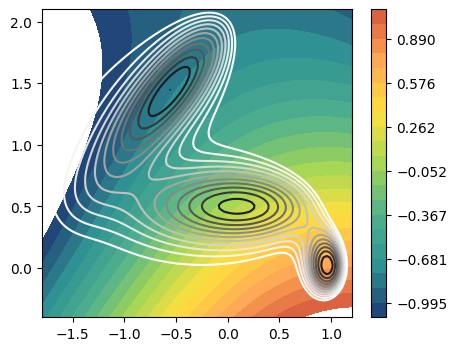

In [15]:
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential_three_states,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=np.linspace(-1.1,1.1,22), ax=ax)
    # plot_isolines_2D(model, component=i, mode='contour', levels=25, ax=ax)

## Run PLUMED simulation

In [16]:
# create folder
SIMULATION_FOLDER = f'{RESULTS_FOLDER}/deepTICA/data'
if run_calculations:
        #subprocess.run(f"mkdir {SIMULATION_FOLDER}", shell=True)

        # generate inputs
        gen_plumed_tica(model_name=f'model_deepTICA.pt', 
                static_model_path=None,
                static_bias_cv='p.y',
                file_path=SIMULATION_FOLDER,
                rfile_path=f'input_data/opes-y/State.data', 
                potential_formula=MULLER_BROWN_FORMULA, 
                opes_mode='OPES_METAD')
        gen_input_md(inital_position='-0.7,1.4', file_path=SIMULATION_FOLDER, nsteps=1000000)
        gen_input_md_potential(file_path=SIMULATION_FOLDER)
        subprocess.run(f'{PLUMED_EXE} ves_md_linearexpansion < input_md.dat', cwd=SIMULATION_FOLDER, shell=True, executable='/bin/bash')
        last_conf = load_dataframe(f'{SIMULATION_FOLDER}/COLVAR').iloc[-1][['p.x', 'p.y']].values

### Visualize sampling

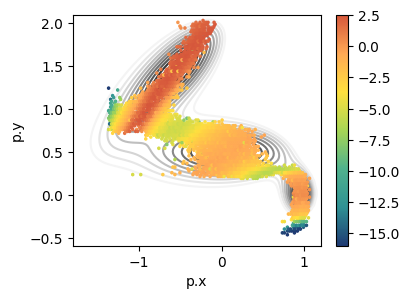

In [17]:
data = load_dataframe(f'{SIMULATION_FOLDER}/COLVAR')
fig, ax = plt.subplots(figsize=(4,3))
plot_isolines_2D(muller_brown_potential_three_states, levels=np.linspace(0,24, 12), max_value=24, ax=ax, mode='contour', zorder=0)

data.plot.hexbin('p.x', 'p.y', C='opes.bias',cmap='fessa', ax=ax)
# plt.savefig(f'{SIMULATION_FOLDER}/sampling.png')
plt.show()

<Axes: xlabel='time'>

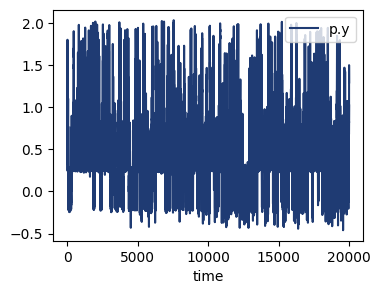

In [18]:
fig, ax = plt.subplots(figsize=(4,3))
data.plot('time', 'p.y', cmap='fessa', ax=ax)

## Analysis


/tmp/ipykernel_3614866/3784803715.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cp = ax.scatter(x,y, c='dimgray', cmap='fessa', alpha=0.2, s=2)


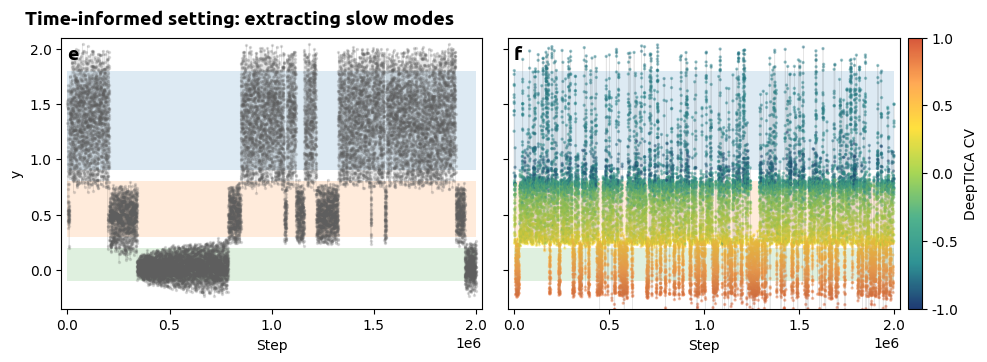

In [19]:
fig, axs = plt.subplots(1,2,figsize=(10,3.5))
plt.subplots_adjust( wspace=0.05)
n_conv = 1

# load data
data = load_dataframe(f'input_data/timelagged/opes-y/COLVAR')

# panel e
ax = axs[0]
# ax.set_aspect('auto')

# apply running average (if any)
x= data.index*100
y=data['p.y']
N=n_conv
y = np.convolve(y,np.ones(N)/N,mode='same')

# shadow state reference
ax.fill_between(np.linspace(0, x.values[-1]), 0.9, 1.8,  alpha=0.15)
ax.fill_between(np.linspace(0, x.values[-1]), 0.3, 0.8,  alpha=0.15)
ax.fill_between(np.linspace(0, x.values[-1]), -0.1, 0.2, alpha=0.15)

# plot data
cp = ax.scatter(x,y, c='dimgray', cmap='fessa', alpha=0.2, s=2)
ax.plot(x,y, alpha=0.1, lw=0.5, color='k')

# labels
ax.set_xlabel('Step')
ax.set_ylabel('y')
ax.xaxis.set_ticks([0.0e6, 0.5e6, 1.0e6, 1.5e6, 2.0e6 ])
ax.yaxis.set_ticks([0.0, 0.5, 1.0, 1.5, 2.0 ])
ax.set_ylim(-0.35,2.1)
ax.set_xlim(-3e4,2e6+3e4)


# panel f
ax = axs[1]
# ax.set_aspect('auto')

# load data
data = load_dataframe(f'{RESULTS_FOLDER}/deepTICA/data/COLVAR')

# apply running average (if any)
x= data.index*100
y=data['p.y']
N=n_conv
y = np.convolve(y,np.ones(N)/N,mode='same')

# shadow state reference
ax.fill_between(np.linspace(0, x.values[-1]), 0.9, 1.8,  alpha=0.15)
ax.fill_between(np.linspace(0, x.values[-1]), 0.3, 0.8,  alpha=0.15)
ax.fill_between(np.linspace(0, x.values[-1]), -0.1, 0.2, alpha=0.15)

# normalize color range
c = data['tica.node-0']
mean_c = c.mean()
range_c = c.max() - c.min()
c = (c - mean_c) / range_c * 2

# plot data
cp = ax.scatter(x,y, c=c, cmap='fessa', alpha=0.4, s=2)
ax.plot(x,y, alpha=0.1, lw=0.5, color='k')

# labels
ax.set_xlabel('Step')
ax.xaxis.set_ticks([0.0e6, 0.5e6, 1.0e6, 1.5e6, 2.0e6 ])
ax.yaxis.set_ticklabels([])
ax.set_ylim(-0.35,2.1)
ax.set_xlim(-3e4,2e6+3e4)

# make visible colorbar
norm = mlp.colors.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(norm=norm,cmap='fessa')
cbar = plt.colorbar(mappable=sm, fraction=0.050, pad=0.02, format='%.1f', ax = ax, ticks=[-1.0, -0.5, 0.0, 0.5, 1.0])#, ax=axs.ravel().tolist())
cbar.set_label('DeepTICA CV',fontsize=10)

fig.text(0.03, 0.98, 'Time-informed setting: extracting slow modes', fontsize=14, fontweight='demi', font='ubuntu')
axs[0].text(-2, 1.9, 'e', fontsize=14, fontweight='demi', font='ubuntu')
axs[1].text(0, 1.9, 'f', fontsize=14, fontweight='demi', font='ubuntu')
# plt.savefig('muller_experiments/figures/examples_timelagged.png', bbox_inches='tight', dpi=200)
plt.tight_layout()
plt.show()